<a href="https://colab.research.google.com/github/gguex/ISH_ressources_cours_ML/blob/main/TP04c_corrige.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Pour modifier la taille de sortie de graphiques dans le notebook
plt.rcParams['figure.figsize'] = [12, 12]
# Pour le traitement des données
from sklearn.preprocessing import StandardScaler
# le kNN et les SVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# Pour la CV
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
file_path = "drive/MyDrive/Colab Notebooks/ml_data/TP4/Social_Network_Ads.csv"
data = pd.read_csv(file_path)
data

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [3]:
# On transforme la variable age en numérique
data["Gender"].replace(["Male", "Female"], [0, 1], inplace=True)
# On standardise et sauve les entrées
inputs = StandardScaler().fit_transform(data.drop(["User ID", "Purchased"], axis=1))
# On prend la sortie
outputs = data["Purchased"]
# On sépare le jeu de données
inputs_train_val, inputs_test, outputs_train_val, outputs_test \
  = train_test_split(inputs, outputs, test_size=0.25, stratify=outputs)

/tmp/ipython-input-775637325.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Gender"].replace(["Male", "Female"], [0, 1], inplace=True)
/tmp/ipython-input-775637325.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Gender"].replace(["Male", "Female"], [0, 1], inplace=True)


In [4]:
# Paramètres pour le nombre de voisins
k_par = list(range(1, 31))
param_dict = {"n_neighbors": k_par}
n_cv = 4
# Recherche sur grille avec CV
knn_classifier = KNeighborsClassifier()
gride_search_knn = GridSearchCV(knn_classifier,
                                param_dict,
                                cv=n_cv)
gride_search_knn.fit(inputs_train_val, outputs_train_val)

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]})

In [5]:
accuracy_knn_test = gride_search_knn.best_estimator_.score(inputs_test, outputs_test)
best_k = gride_search_knn.best_params_["n_neighbors"]
print(f"kNN: meilleure paramètre k = {best_k}")
print(f"kNN: meilleure exactitude d'entrainement = "
      f"{gride_search_knn.best_score_: .2%}")
print(f"kNN: meilleure exactitude de test = {accuracy_knn_test: .2%}")

kNN: meilleure paramètre k = 9
kNN: meilleure exactitude d'entrainement =  91.00%
kNN: meilleure exactitude de test =  89.00%


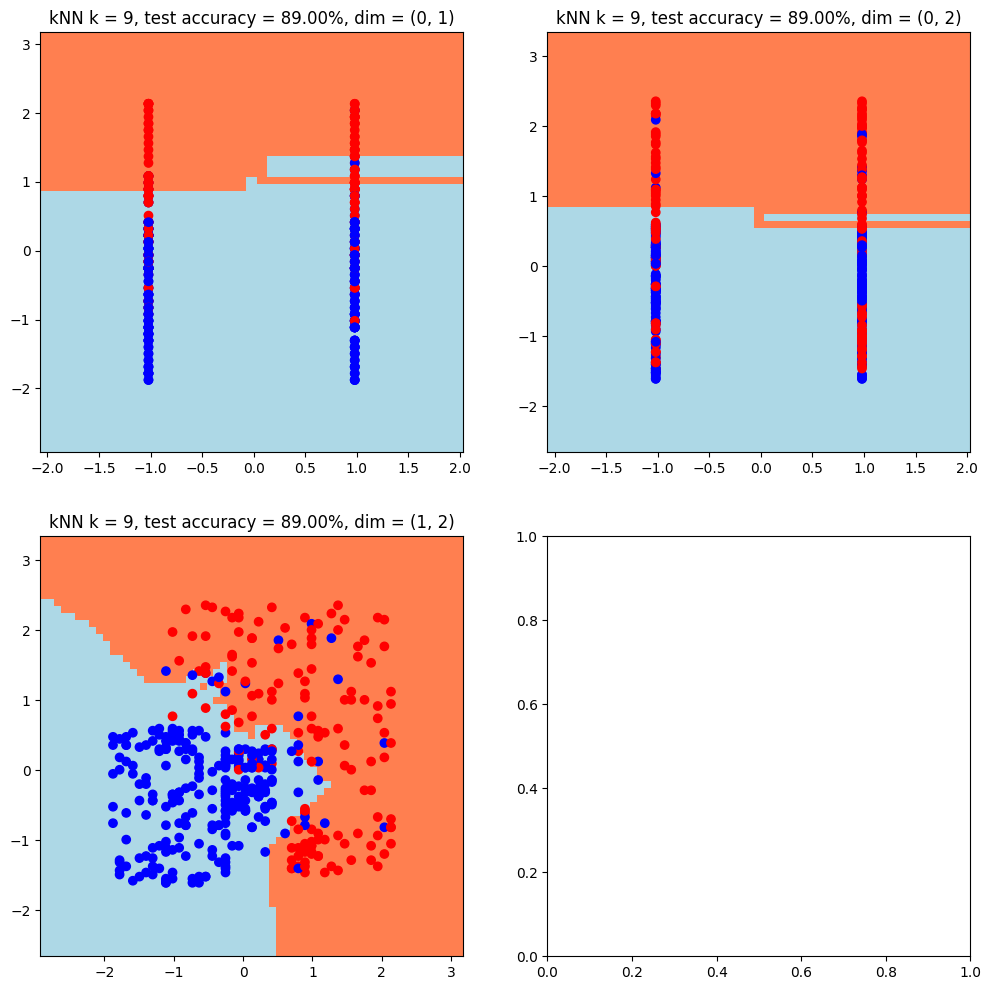

In [6]:
# Les dimensions que nous allons examiner
dim_list = [(0, 1), (0, 2), (1, 2)]
# La position des graphs dans le carré
pos_list = [(0, 0), (0, 1), (1, 0)]
# Nos couleurs
mesh_cmap = ListedColormap(["lightblue", "coral"])
points_cmap = ListedColormap(["blue", "red"])
# La taille de la mesh
mesh_size = 0.1

# On créée le graphique
fig, axs = plt.subplots(2, 2)

# On fait une boucle sur les dimensions
for i, dim in enumerate(dim_list):
  # On restreint les données
  X = inputs[:, dim]
  # On fixe les limites
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  # On définit notre mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                        np.arange(y_min, y_max, mesh_size))
  # On définit les inputs
  new_values = np.c_[xx.ravel(), yy.ravel()]
  grid_input = np.zeros((new_values.shape[0], inputs.shape[1]))
  grid_input[:, dim] = new_values
  # On fait les prédictions, que l'on transforme en valeurs numériques
  grid_pred = gride_search_knn.best_estimator_.predict(grid_input)
  grid_pred = grid_pred.reshape(xx.shape)

  # On fait le graphique
  axs[pos_list[i]].pcolormesh(xx, yy, grid_pred, cmap=mesh_cmap)
  axs[pos_list[i]].scatter(X[:, 0], X[:, 1], c=outputs, cmap=points_cmap)
  axs[pos_list[i]].set_title(f"kNN k = {best_k}, test accuracy = {accuracy_knn_test:.2%}, dim = {dim}")

In [7]:
c_par = np.linspace(1, 10, 20)
gamma_par = np.linspace(0.01, 2, 20)
param_dict = {"C": c_par, "gamma": gamma_par}
n_cv = 4
svm_classifier = SVC()
# Recherche sur grille avec CV
gride_search_svm = GridSearchCV(svm_classifier,
                                param_dict,
                                cv=n_cv,
                                verbose=0)
gride_search_svm.fit(inputs_train_val, outputs_train_val)

GridSearchCV(cv=4, estimator=SVC(),
             param_grid={'C': array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ]),
                         'gamma': array([0.01      , 0.11473684, 0.21947368, 0.32421053, 0.42894737,
       0.53368421, 0.63842105, 0.74315789, 0.84789474, 0.95263158,
       1.05736842, 1.16210526, 1.26684211, 1.37157895, 1.47631579,
       1.58105263, 1.68578947, 1.79052632, 1.89526316, 2.        ])})

In [8]:
accuracy_svm_test = gride_search_svm.best_estimator_.score(inputs_test, outputs_test)
print(f"SVM: meilleures paramètres {gride_search_svm.best_params_}")
print(f"SVM: meilleure exactitude d'entrainement = "
      f"{gride_search_svm.best_score_: .2%}")
print(f"SVM: meilleure exactitude de test = {accuracy_svm_test: .2%}")

SVM: meilleures paramètres {'C': np.float64(2.4210526315789473), 'gamma': np.float64(2.0)}
SVM: meilleure exactitude d'entrainement =  91.33%
SVM: meilleure exactitude de test =  89.00%


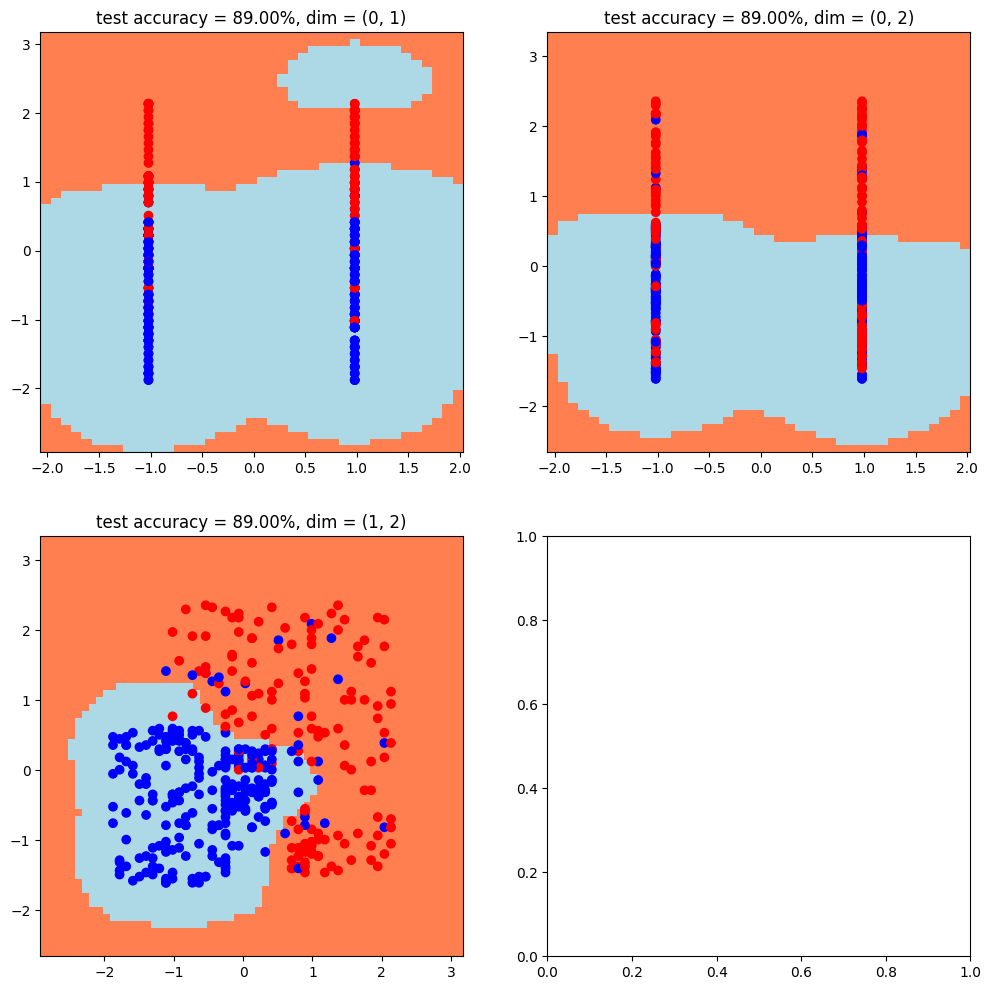

In [9]:
# On créée le graphique
fig, axs = plt.subplots(2, 2)

# On fait une boucle sur les dimensions
for i, dim in enumerate(dim_list):
  # On restreint les données
  X = inputs[:, dim]
  # On fixe les limites
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  # On définit notre mesh
  xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                        np.arange(y_min, y_max, mesh_size))
  # On définit les inputs
  new_values = np.c_[xx.ravel(), yy.ravel()]
  grid_input = np.zeros((new_values.shape[0], inputs.shape[1]))
  grid_input[:, dim] = new_values
  # On fait les prédictions, que l'on transforme en valeurs numériques
  grid_pred = gride_search_svm.best_estimator_.predict(grid_input)
  grid_pred = grid_pred.reshape(xx.shape)

  # On fait le graphique
  axs[pos_list[i]].pcolormesh(xx, yy, grid_pred, cmap=mesh_cmap)
  axs[pos_list[i]].scatter(X[:, 0], X[:, 1], c=outputs, cmap=points_cmap)
  axs[pos_list[i]].set_title(f"test accuracy = {accuracy_svm_test:.2%}, "
                             f"dim = {dim}")